In [1]:
import numpy as np
from matplotlib import pyplot as plt
import geoana
import scipy.sparse as sp

import polarizability_model as pm
import uxo_utils

from matplotlib import rcParams
rcParams["font.size"] = 14

## Simple coincident loop system

In [2]:
# define system geometry -- transmitter is a horizontal square loop,
# receivers are in the centre, measure x, y, z data
rx_width=0.01
tx_width=1
sensorinfo = uxo_utils.CustomSensorInfo.coincident_system(
    tx_width=tx_width, rx_width=rx_width
)
ordnance = uxo_utils.load_ordnance_dict()

In [3]:
times = ordnance["ISO Small"]["times"]
sensor_table = sensorinfo.measNum2TxRxRxcCube()

### Define classes 

In [4]:
classes = {
    0: "Background", 
    1: "ISO Small", 
    2: "ISO Medium", 
    3: "ISO Large", 
    4: "4-in Sphere",  # clutter 
}

### survey geometry 

In [5]:
n_lines = 1
line_length = 3
z_tx = 0.25  # transmitter is 25cm above the ground 
along_line_spacing = 0.2  # 20cm along line spacing 

survey_dict = uxo_utils.create_survey(
    sensorinfo,
    times, 
    line_length=line_length,
    along_line_spacing=along_line_spacing,
    # line_spacing=line_spacing,
    n_lines=n_lines,
    starting_point=np.r_[-1, 0]*line_length/2,
    z=z_tx,
    pitch=0,
    roll=0,
    yaw=0,
)

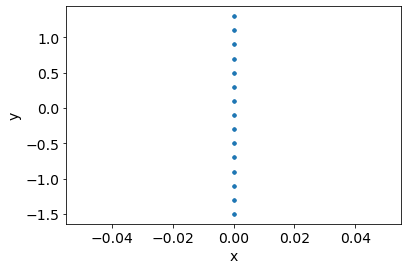

In [6]:
fig, ax = plt.subplots(1,1)

for l in np.unique(survey_dict["line"]): 
    inds = survey_dict["line"] == l
    ax.plot(
        survey_dict["pos"][inds, 0], survey_dict["pos"][inds, 1], ".", 
        color="C1" if np.all(survey_dict["yaw"][inds] > np.pi/2 ) else "C0"
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")

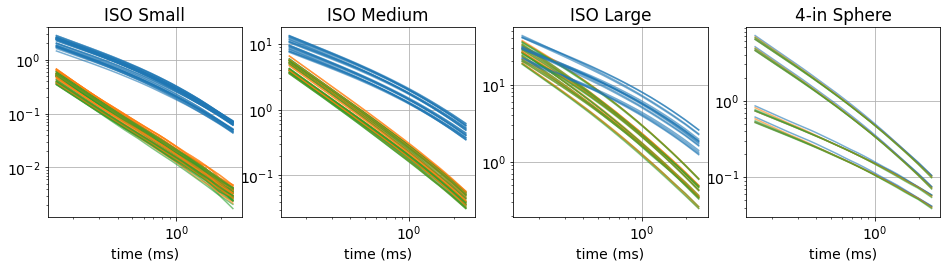

In [7]:
fig, ax = plt.subplots(1, len(classes.values())-1, figsize=(16, 3.5))

i = 0
for item in classes.values():
    if item in ordnance.keys():
        for ord_ind in range(len(ordnance[item]["L3"])):
            L1, L2, L3 = (ordnance[item][l][ord_ind] for l in ["L3", "L2", "L1"])
            ax[i].loglog(times, L1, f"C0", alpha=0.6)
            ax[i].loglog(times, L2, f"C1", alpha=0.6)
            ax[i].loglog(times, L3, f"C2", alpha=0.6)
        ax[i].grid()
        ax[i].set_title(item)
        ax[i].set_xlabel("time (ms)")
        i += 1

## create survey

In [8]:
src_list = []
nrx = len(sensorinfo.receivers)
rx_area = np.max(np.abs(np.diff(sensorinfo.receivers[0].shape, axis=0)))**2

for i, txi in enumerate(survey_dict["txnum"]):
    tx = sensorinfo.transmitters[txi]
    tx_corners = tx.shape + survey_dict["xyz"][i, :]
    tx_corners = np.vstack([tx_corners, tx_corners[:1, :]])  # close the loop

    receivers = pm.MagneticFluxDensityReceiver(
        np.atleast_2d(survey_dict["xyz"][i, :]), 
        components=[rx.component for rx in sensorinfo.receivers],
        area=rx_area
    )
    src = pm.MagneticControlledSource(
        receiver_list=[receivers], location=tx_corners, current=1
    )
    src_list.append(src)
survey = pm.Survey(src_list)

In [ ]:
def run_simulation(ord_loc, ord_ypr, L1, L2, L3): 
    sim = pm.SimulationPolarizabilityModel(np.atleast_2d(ord_loc), survey)
    A = uxo_utils.rotation_matrix(ord_ypr[0], ord_ypr[1], ord_ypr[2])
    
    
    for j, P in enumerate(polarizabilities): 
        data_pm[:, :, j] = sum([
            sim.dpred(P[:, k]) for k in range(3)
        ]).reshape(survey_dict["xyz"].shape[0], 3).T
